# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP
from adjustText import adjust_text

In [2]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

This is an implementation of naive Skip-Gram, where we use softmax and don't update all context vectors simultaneously, so all center-context pairs are equal for updating of NN weights

Creating the batcher which implementation is almost equal to batcher in Task 2
Differences:
- Instead of numpy array, PyTorch tensors are generated
- Stride is added for experimenting with skipping several central words (=1 for the final model)
- Also random window size from 1 to max_window_size was implemented, but code was removed because it was not used in the final model

### Preparing for training

In [3]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        filtered_token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(filtered_token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
    
    def _create_sliding_window(self, window_size, stride):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size, stride):
            center_word = self.vectorized_tokens[i:i+1]
            left_context = self.vectorized_tokens[max(0, i - window_size): i]
            right_context = self.vectorized_tokens[i + 1: min(tokens_size, i + window_size + 1)]
            yield from product(center_word, chain(left_context, right_context))
        
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        
    def generate_batches(self, window_size=1, stride=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size, stride)
        batch = list(zip(*islice(window, batch_size)))
        x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

        if drop_last:
            while batch and len(batch[0]) == batch_size:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
        else:
            while batch:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

In [ ]:
torch.norm

Creating classifier for training word embeddings with the following properties:
- PyTorch layers are used for implementing classifier:
    - Embedding (W matrix from paper)
    - Linear (W_prime transposed from paper)
        - Bias is not trained for training all parameters in matrix
- Weight normalization for word vectors is used (see paper - https://arxiv.org/abs/1602.07868)
    - With this type of normalization, NN is converging much faster with final loss value less than without normalization (with all the same other parameters), also it seems that for intrinsic task (closest vectors and word analogies) it gives better quality
    - I've used weight normalization along word vectors' dimensions, not word vectors itself, after experimenting with both normalizations, I've concluded that converging and quality for per-dimension normalization is better, more time is required for exploring.
    - It was confusing for me but argument 'dim' for nn.utils.weight_norm() function normalizes along columns if dim=0, and with dim=1 - along rows.
    - I've also tried several different configuraions, but all of them were not as good as weight normalization by word-vector dimensions
        - Training without any normalization (only embedding and fc1 layers)
        - Normalizing using max_norm=1 argument for nn.Embedding layer, but unfortunately after training vectors were not normalized to 1 (I've found the post on the forum that it is probably a bug - https://discuss.pytorch.org/t/normalizing-embeddings/7696)
        - Normalizing using torch.norm function
        - Weight normalization for each word vector

In [4]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super().__init__()

        self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
                                              embedding_dim=embedding_size), dim=1)

        self.fc1 = nn.utils.weight_norm(nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size,
                             bias=False), dim=1)
        
    def forward(self, x_in):
        x_embedded = self.embedding(x_in)
        y_out = self.fc1(x_embedded)
        
        return y_out

Setting all possible random states to fixed number

In [5]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

Create namespace with all parameters for training (specified values were used for the final model)

In [6]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10,
    window_size = 3,
    stride = 1,
    batch_size = 1024,
    learning_rate = 0.03,
    iterations = 1000,
    save_iterations = 100,
    early_stopping_criteria = 1e8,
    factor=0.5,
    patience=5000,
    
    cuda=True
)

Create functions for creating and updating necessary parameters while training

In [7]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], # args.learning_rate
            'batch_idx': 0,
            'loss': [],
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

Check if we can use GPU or CPU
- GPU was used to train NN, now CUDA is false for saving resources

In [8]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: False


Create batcher, prepare data, and calculate vocabulary size

In [9]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

### Main Training Cycle

- Only one epoch is used because of enough dataset size for training
- Learning rate scheduler is used to decrease learning rate while loss is not decreasing for specific number of iterations
- Monitoring training progress using tqdm_notebook (not displayed because of restarting notebook after training and saving all necessary information to files)
- Tracking train state for using early stopping and saving intermediate models in file (early stopping is not used in final model)
- Cumulative moving average is used for tracking loss 

There are about 16.5 millions tokens in preprocessed text, so with window_size=3 there are about 99 millions pairs are used in training (1 epoch)  
Total training time is about 55 minutes on GPU P4 on Google Cloud Platform (about 30 batches per second with batch_size=1024)

In [ ]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size)
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

epoch_size = 2 * (args.window_size * len(sg_batcher.tokens) 
                  - np.math.factorial(args.window_size)) // (args.batch_size * args.stride)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=args.factor,
                                                 patience=args.patience)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
                          total=epoch_size)

batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                              batch_size=args.batch_size)

train_state = make_train_state(args)

writer = SummaryWriter(log_dir='logs/task_3', comment='embedding_training')

running_loss = 0.
classifier.train()

try:
    for batch_idx, (x_batch, labels_batch) in enumerate(batch_generator, 1):
        x_batch = x_batch.to(args.device)
        labels_batch = labels_batch.to(args.device)

        optimizer.zero_grad()

        y_pred = classifier(x_in=x_batch)

        loss = loss_func(y_pred, labels_batch)
        loss_value = loss.item()
        running_loss += (loss_value - running_loss) / (batch_idx)
        loss.backward()
        
        learning_rate = optimizer.param_groups[0]['lr']
        
        train_state['batch_idx'] = batch_idx
        train_state['loss'].append(running_loss)
        train_state['learning_rate'].append(learning_rate)

        train_state = update_train_state(args=args,
                                         model=classifier,
                                         train_state=train_state)

        train_params = dict(loss=running_loss,
                            lr=learning_rate,
                            early_step=train_state['early_stopping_step'],
                            early_best=train_state['early_stopping_best_val'])
        train_bar.set_postfix(train_params)
        train_bar.update()
        
        optimizer.step()
        
        scheduler.step(train_state['loss'][-1])

        if train_state['stop_early'] or (batch_idx == epoch_size):
            torch.save(classifier.state_dict(), str(train_state['model_file_name']) + '_last')
            break
except KeyboardInterrupt:
    print('Exit training')

### Visualizing of the training process results

Loss values

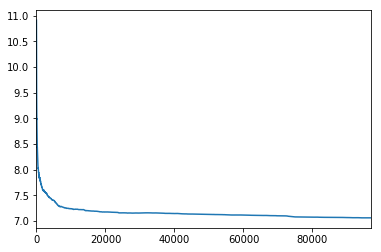

In [11]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

Learning rate values

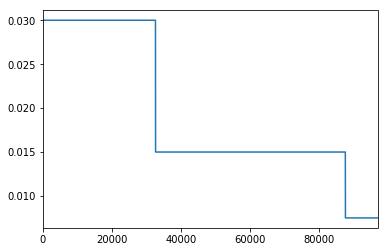

In [12]:
train_state_df['learning_rate'].plot()
plt.show()

Get matrices with word vectors, calculate average matrix, and save all theses matrices to file  
(Commented because it was used right after training)

In [11]:
# W = classifier.embedding.weight.detach().cpu().numpy()
# W_prime = classifier.fc1.weight.detach().cpu().numpy()

# W_avg = (W + W_prime) / 2
# np.savez(args.weights_path, W=W, W_prime=W_prime, W_avg=W_avg)

### Visualizing word vectors

Load saved weights for exploring final word vectors

In [16]:
weights = np.load('../models/final/task_3/weights.npz')
W = weights['W']
W_prime = weights['W_prime']

W_avg = weights['W_avg']

In [13]:
metadata = list(sg_batcher.token_to_idx)

writer = SummaryWriter(log_dir='logs_final/task_3', comment='embedding_training')
writer.add_embedding(W_avg, metadata=metadata, tag='W_avg')

We can now visualize words cloud in TensorBoard using PCA or TSNE

<img src="images/task_3/1.PNG" style="height:480px width:640px">

<img src="images/task_3/2.PNG" style="height:480px width:640px">

<img src="images/task_3/3.PNG" style="height:480px width:640px">

<img src="images/task_3/4.PNG" style="height:480px width:640px">

<img src="images/task_3/5.PNG" style="height:480px width:640px">

**Conclusion**
- After exploring words, it seems that word cloud on the left side (picture 1) contains not popular words, and its neighbors don't have meaningful neigbors, whereas words in the right cloud are more frequent and have meaningful neighbors (pictures 2-5)

Let's check values in all 3 matrices using heatmaps

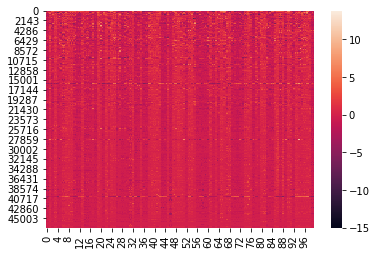

In [21]:
sns.heatmap(W)
plt.show()

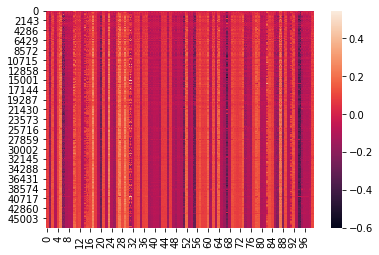

In [22]:
sns.heatmap(W_prime)
plt.show()

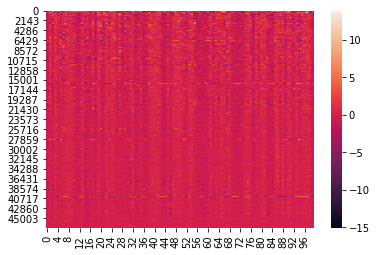

In [23]:
sns.heatmap(W_avg)

**Conclusion**
- Matrices for central and context words have different scale and distribution.

Create function to plot word vectors after dimensionality reduction with auto-adjusting of label positions 

In [29]:
def plot_embeddings(embs_reduced, token_to_idx, tokens, fig_size=(12, 12)):
    token_embs = embs_reduced[[token_to_idx[token] for token in tokens]]
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(token_embs[:, 0], token_embs[:, 1], alpha=0.3)
    
    texts = [plt.text(token_embs[i, 0], token_embs[i, 1], f'{token}') for i, token in enumerate(tokens)]
    adjust_text(texts)

Apply PCA and visualize results

In [30]:
%%time
pca = PCA(n_components=2, random_state=42)
embs_pca = pca.fit_transform(W_avg)

CPU times: user 340 ms, sys: 0 ns, total: 340 ms
Wall time: 87 ms


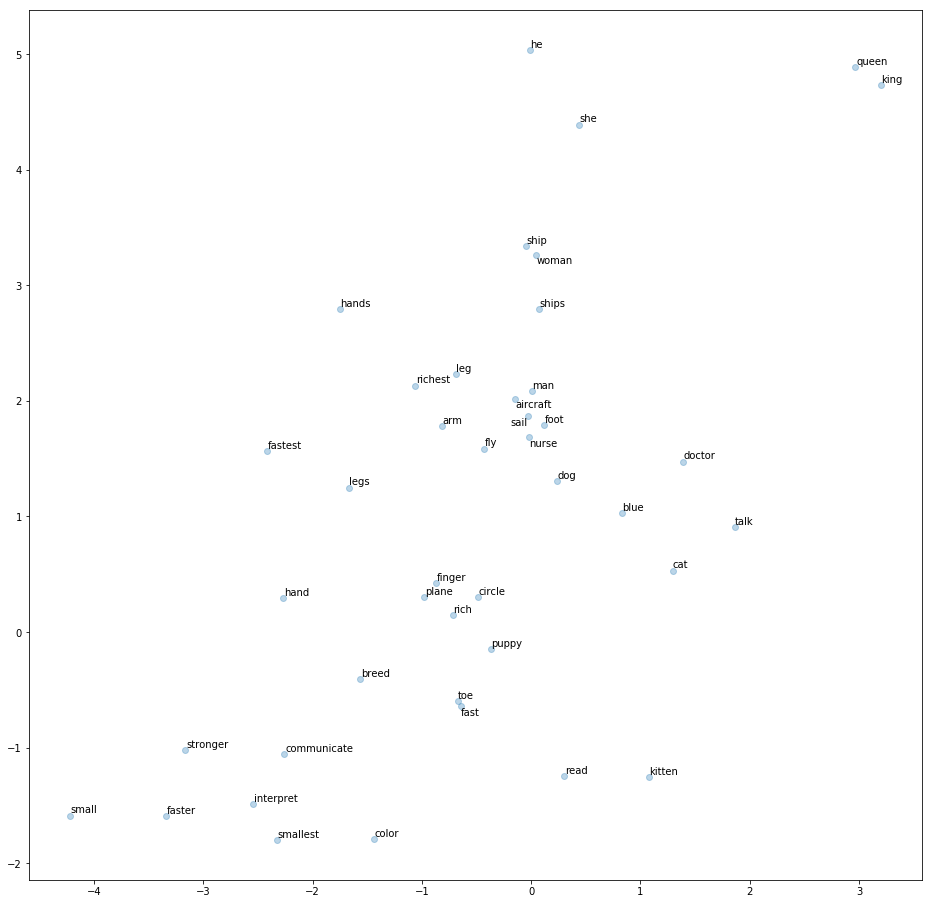

In [31]:
plot_embeddings(embs_pca, sg_batcher.token_to_idx, words, fig_size=(16, 16))

Apply TSNE and visualize results
- Multicore version of TSNE is used for speeding up the process (not from sklearn)

In [21]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=-1)
embs_tsne = tsne.fit_transform(W_avg)

CPU times: user 22min 59s, sys: 9min 26s, total: 32min 25s
Wall time: 4min 6s


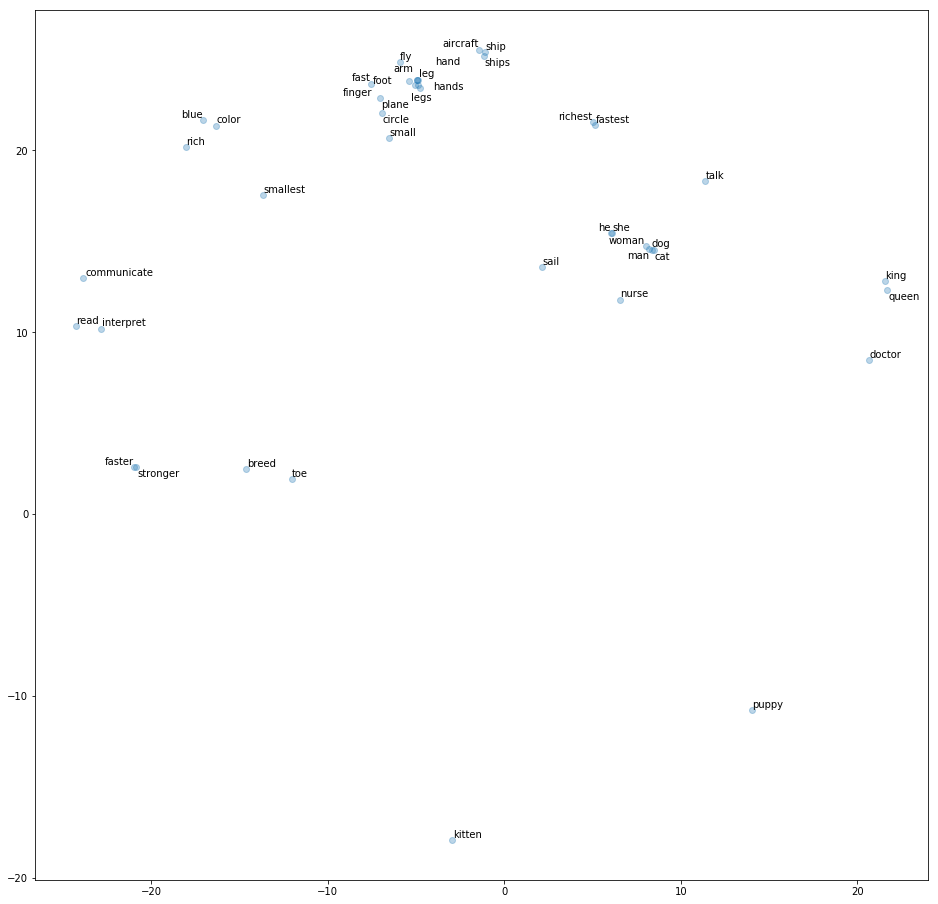

In [33]:
plot_embeddings(embs_tsne, sg_batcher.token_to_idx, words, fig_size=(16, 16))

Apply UMAP and visualize results

In [28]:
%%time
umap = UMAP(metric='cosine')
embs_umap = umap.fit_transform(W_avg)

CPU times: user 1min 57s, sys: 16.2 s, total: 2min 13s
Wall time: 1min 47s


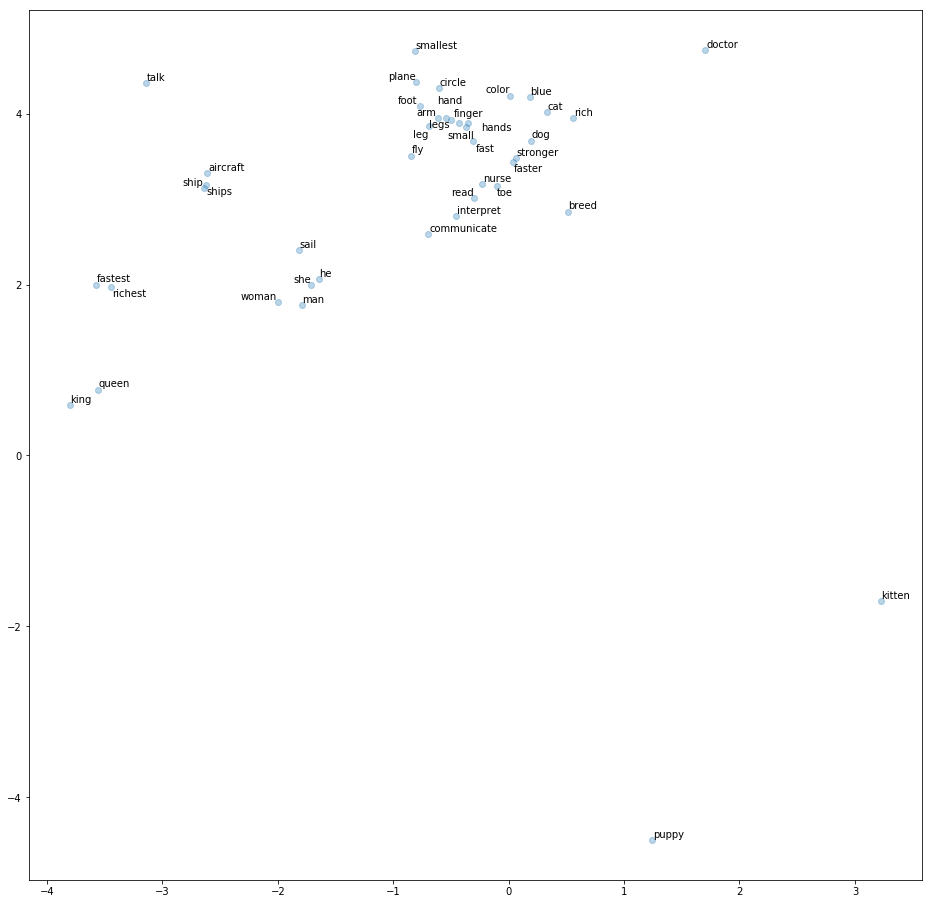

In [34]:
# tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_umap, sg_batcher.token_to_idx, words, fig_size=(16, 16))

**Conclusion**
- It seems that TSNE and UMAP are better for visualizing relationships among the words (maybe because this algorithms are non-linear and try to preserve distances or topological structure between points)

### Intrinsic evaluation

Preparing words for visualizing and intrinsic evaluation (word analogies and closest vectors)

In [40]:
words = []
words.extend(['man', 'he', 'woman', 'she'])
words.extend(['fly', 'plane', 'aircraft', 'sail', 'ship', 'ships', 'circle'])
words.extend(['kitten', 'cat', 'puppy', 'dog'])
words.extend(['leg', 'legs', 'hand', 'hands'])
words.extend(['blue', 'color', 'dog', 'breed'])
words.extend(['toe', 'finger', 'foot', 'hand', 'arm'])
words.extend(['talk', 'communicate', 'read', 'interpret'])
words.extend(['man', 'king', 'woman', 'queen', 'doctor'])
words.extend(['man', 'doctor', 'woman', 'nurse'])
words.extend(['fast', 'fastest', 'small', 'smallest', 'rich', 'richest', 'faster', 'stronger'])
words = list(set(words))

Create class for exploring neighbors and word analogies

In [41]:
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx 
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric
        
        self.index = AnnoyIndex(vectors.shape[1], metric=metric)
        
        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])
        
        self.index.build(50)
        print('Building index is finished')
        
    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]
    
    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]
    
    def compute_closest_tokens(self, target_token, n=1):
        vector = self.get_embedding(target_token)
        closest_tokens = self.get_closest_to_vector(vector, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token != target_token]
        print(f'{target_token}: {closest_tokens}')
    
    def compute_analogy(self, token1, token2, token3, n=30):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1
        
        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]
        
        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return
        
        print(f'{token1}:{token2} :: {token3}:{closest_tokens}')

For evaluation, euclidean metric was used on trained average word vectors ((W + W_prime) / 2), without normalization after training. With normalization for each word vector, euclidean distance will be equal to cosine distance (because "Cosine distance is equivalent to Euclidean distance of normalized vectors", https://github.com/spotify/annoy), but it seems that normalization for each word vector or dimension break several syntactic or semantic analogies (maybe onlye for chosed words for evaluation, need more time for detailed exploration).  
Also different metrics were tested from Annoy package, but euclidean distance was chosen as the best metric for this specific evaluation.

In [42]:
emb_explorer = EmbeddingsExplorer(sg_batcher.token_to_idx, W_avg, metric='euclidean')
emb_explorer

Building index is started
Building index is finished


**Word Analogies**

This analogy is correct, word vectors capture gender difference ("she")

In [43]:
emb_explorer.compute_analogy('man', 'he', 'woman')

man:he :: woman:['she', 'briefly', 'prison', 'herself', 'afterwards', 'subsequently', 'himself', 'him', 'parents', 'publicly', 'again', 'marry', 'apparently', 'secretly', 'marriage', 'succeed', 'wounded', 'reportedly', 'abroad', 'pregnant', 'allegedly', 'personally', 'her', 'consul', 'finally', 'pursue', 'resign', 'appointment', 'badly']


This analogy is wrong (something like "ship" was expected). It seems that word vector captures the meaning of the "plane" from math, so we can see words like "circle", "rotation", "column" etc.

In [44]:
emb_explorer.compute_analogy('fly', 'plane', 'sail')

fly:plane :: sail:['circle', 'arc', 'column', 'rotation', 'outer', 'ring', 'arch', 'intersection', 'probe', 'imaginary', 'curvature', 'burst', 'mound', 'gate', 'crest', 'junction', 'columns', 'stream', 'orbital', 'loop', 'radius', 'crater', 'flux', 'triangle', 'path', 'axis', 'chain', 'segment', 'grid']


If we change the word "plane" to "aircraft" - correct analogy will be captured ("submarine", "ships"), but there are also many words with military-related meaning

In [145]:
emb_explorer.compute_analogy('fly', 'aircraft', 'sail')

fly:aircraft :: sail:['missiles', 'artillery', 'submarine', 'missile', 'reconnaissance', 'infantry', 'cruise', 'tanks', 'submarines', 'tank', 'patrol', 'fighter', 'weapons', 'planes', 'jet', 'guns', 'launch', 'rocket', 'armored', 'helicopters', 'ships', 'fleet', 'operations', 'carriers', 'bomber', 'armoured', 'ballistic', 'carrier', 'missions']


This analogy was captured correctly ("dog")

In [146]:
emb_explorer.compute_analogy('kitten', 'cat', 'puppy')

kitten:cat :: puppy:['dog', 'bird', 'wolf', 'magic', 'soup', 'cow', 'devil', 'pepper', 'tiger', 'horn', 'monster', 'flower', 'dwarf', 'killer', 'beast', 'pet', 'chorus', 'honey', 'mask', 'bean', 'jacket', 'rabbit', 'grass', 'chocolate', 'grey', 'kid', 'dragon', 'eyed', 'hammer']


But it seems that reverse analogy was not captured (expected something like "puppy")

In [49]:
emb_explorer.compute_analogy('cat', 'kitten', 'dog')

cat:kitten :: dog:['altruistic', 'farmhouse', 'backbench', 'cheerful', 'wafers', 'wannsee', 'classmate', 'conifers', 'carpenters', 'disenfranchised', 'blasted', 'teleprinter', 'flashback', 'complexion', 'jacky', 'divergences', 'indecisive', 'pinto', 'orchids', 'trustee', 'rooting', 'replayed', 'shams', 'lind', 'lawns', 'theatrically', 'gourmet', 'pronouncement', 'believable', 'dashing']


Analogy from specific to common is captured correctly (expected something like "breed")

In [51]:
emb_explorer.compute_analogy('blue', 'color', 'dog')

blue:color :: dog:['breed', 'fitting', 'joke', 'straightforward', 'duplicate', 'confusing', 'perfect', 'trick', 'realistic', 'humorous', 'stupid', 'magic', 'luck', 'clip', 'melody', 'mirrors', 'puzzle', 'voice', 'meter', 'fancy', 'bunch', 'typing', 'smell', 'strange', 'creature', 'curious', 'parody', 'thread', 'pleasing']


Analogy from part to the whole is almost captured correctly (expected something like "hand", but "arm" is captured)

In [150]:
emb_explorer.compute_analogy('toe', 'finger', 'foot')

toe:finger :: foot:['leg', 'neck', 'legs', 'arm', 'fingers', 'bottom', 'floor', 'shoulder', 'tail', 'bow', 'deck', 'edges', 'stones', 'wheel', 'rear', 'walking', 'face', 'wings', 'roof', 'front', 'plate', 'door', 'nose', 'shoulders', 'horse', 'shaft', 'vertical', 'hanging']


Word analogy for the process is also has meaningful result (expected something like "interpret")

In [151]:
emb_explorer.compute_analogy('talk', 'communicate', 'read')

talk:communicate :: read:['translate', 'convert', 'manipulate', 'commands', 'modify', 'integrate', 'reproduce', 'identify', 'detect', 'confuse', 'render', 'rendered', 'overcome', 'execute', 'automatically', 'checking', 'classify', 'dynamically', 'modifications', 'instructions', 'choosing', 'utilize', 'evolve', 'employ', 'correctly', 'interpret', 'proceed', 'carefully']


Classic word analogy is also captured but not in top-1 (expected "queen"), many words which are related to roalty are also captured royalty

In [152]:
emb_explorer.compute_analogy('man', 'king', 'woman')

man:king :: woman:['viii', 'prince', 'son', 'vii', 'heir', 'crowned', 'henry', 'queen', 'elizabeth', 'iii', 'augustus', 'khan', 'cousin', 'daughter', 'constantine', 'princess', 'grandson', 'bishop', 'clement', 'caesar', 'aragon', 'vi', 'tsar', 'colonel', 'regent', 'alexander', 'successor', 'throne', 'innocent']


Stereotypes with gender and job titles are also captured
- 1st analogy: "nurse" is top-1 word
- 2nd analogy: "detective" is in top-5 words

In [55]:
emb_explorer.compute_analogy('man', 'doctor', 'woman')

man:doctor :: woman:['nurse', 'secretly', 'colleague', 'lawyer', 'farmer', 'mrs', 'gertrude', 'child', 'nude', 'twins', 'stern', 'fellow', 'blonde', 'oswald', 'teenager', 'mortal', 'lover', 'reverend', 'morrison', 'servant', 'marrying', 'martha', 'emma', 'girlfriend', 'lucy', 'businessman', 'divorce', 'longtime']


In [56]:
emb_explorer.compute_analogy('woman', 'doctor', 'man')

woman:doctor :: man:['messenger', 'wizard', 'wolf', 'magic', 'detective', 'gene', 'trumpet', 'genius', 'reads', 'ape', 'morrison', 'guy', 'explores', 'clich', 'slayer', 'quotes', 'spider', 'skeptic', 'macbeth', 'depicts', 'knuth', 'barker', 'paradox', 'saga', 'mad', 'protagonist', 'recounts', 'novella']


Directions analogy is also captured (expected 'top')

In [158]:
# right:left :: bottom:top
emb_explorer.compute_analogy('right', 'left', 'bottom')

right:left :: bottom:['edge', 'crossing', 'rolling', 'plate', 'foot', 'sits', 'floor', 'deck', 'underneath', 'ends', 'top', 'junction', 'edges', 'finger', 'pitch', 'neck', 'ridge', 'wheel', 'gate', 'facing', 'shaft', 'walking', 'drops', 'threw', 'leg', 'bow', 'reaches', 'tip', 'bend']


Word vectors also capture syntaсtic analogies
- 1st analogy: expected "hands"
- 2nd analogy: expected "smallest"
- 3rd analogy: expected "oldest"
- 4th analogy: expected "stronger"

In [53]:
emb_explorer.compute_analogy('leg', 'legs', 'hand')

leg:legs :: hand:['fingers', 'side', 'hands', 'shoulder', 'neck', 'face', 'clothes', 'surfaces', 'edges', 'bodies', 'finger', 'horns', 'teeth', 'balls', 'shoulders', 'holes', 'wooden', 'sticks', 'ingredients', 'leather', 'angles', 'stones', 'wear', 'hair', 'bones', 'eyes', 'colored', 'pulling']


In [155]:
emb_explorer.compute_analogy('fast', 'fastest', 'small')

fast:fastest :: small:['large', 'vast', 'huge', 'substantial', 'coastal', 'growing', 'significant', 'poorest', 'outlying', 'proportion', 'comprised', 'houses', 'surrounding', 'farms', 'enclaves', 'overwhelming', 'fertile', 'comprising', 'presence', 'larger', 'neighbouring', 'richest', 'northernmost', 'comprise', 'portion', 'alpine', 'wealthiest', 'sparsely']


In [65]:
emb_explorer.compute_analogy('large', 'largest', 'old')

large:largest :: old:['oldest', 'longest', 'biggest', 'capital', 'tallest', 'renamed', 'ninth', 'third', 'epic', 'eighth', 'norse', 'saga', 'northeastern', 'chronicle', 'era', 'americas', 'chronicles', 'lies', 'festival', 'basin', 'infamous', 'visited', 'seventh', 'arrival', 'bible', 'originates', 'devil', 'flourished']


In [157]:
emb_explorer.compute_analogy('fast', 'faster', 'strong')

fast:faster :: strong:['stronger', 'wider', 'slower', 'weaker', 'larger', 'substantial', 'greater', 'considerably', 'broader', 'substantially', 'considerable', 'smaller', 'lighter', 'fewer', 'simpler', 'vastly', 'profound', 'powerful', 'subtle', 'heavier', 'tremendous', 'broad', 'significant', 'harder', 'gradual', 'sophisticated', 'noticeable', 'direct']


**Top closest words**

In [60]:
for word in words:
    emb_explorer.compute_closest_tokens(word, n=10)

richest: ['wealthiest', 'poorest', 'northernmost', 'kiribati', 'punjab', 'kerala', 'busiest', 'heartland', 'prefecture']
plane: ['rotation', 'deck', 'loop', 'circle', 'ring', 'column', 'tube', 'probe', 'beam']
faster: ['slower', 'cheaper', 'shorter', 'harder', 'bigger', 'lighter', 'heavier', 'safer', 'flexible']
legs: ['teeth', 'neck', 'fingers', 'wings', 'shoulders', 'shoulder', 'clothes', 'nose', 'leg']
rich: ['diamonds', 'tin', 'butter', 'soft', 'chicken', 'cheese', 'diamond', 'sweet', 'wine']
breed: ['calf', 'cake', 'goat', 'fitting', 'meal', 'polyhedron', 'spicy', 'sticky', 'glow']
arm: ['leg', 'bow', 'finger', 'shoulder', 'wheel', 'thumb', 'shoulders', 'wings', 'fingers']
ships: ['carriers', 'fleet', 'boats', 'infantry', 'ship', 'planes', 'patrol', 'cavalry', 'crew']
she: ['he', 'herself', 'pregnant', 'marry', 'woman', 'secretly', 'suddenly', 'reportedly', 'mother']
doctor: ['morrison', 'guy', 'detective', 'researcher', 'farmer', 'wolf', 'servant', 'playboy', 'costello']
color: [

**Conclusion**
- Trained word vectors can capture both syntactic and semantic relationships, but of course not ideal and not always, maybe because of the limit of the dataset size and training time and specificity of the text.
- Besides synonyms and related words among neighbors, there are a lot of antonyms in the closest words, probable reason is that these close words are used in the same contexts frequently